<a href="https://colab.research.google.com/github/offthetab/Lung_Cancer_Prediction/blob/main/Lung_Cancer_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory
mv: cannot stat './kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
!kaggle datasets download 'thedevastator/cancer-patients-and-air-pollution-a-new-link'

Dataset URL: https://www.kaggle.com/datasets/thedevastator/cancer-patients-and-air-pollution-a-new-link
License(s): other
  0% 0.00/7.36k [00:00<?, ?B/s]
100% 7.36k/7.36k [00:00<00:00, 13.6MB/s]


In [6]:
!unzip cancer-patients-and-air-pollution-a-new-link.zip

Archive:  cancer-patients-and-air-pollution-a-new-link.zip
  inflating: cancer patient data sets.csv  


In [72]:
%%capture
!pip install shap

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix

import shap

import warnings
warnings.filterwarnings('ignore')

In [159]:
data = pd.read_csv("cancer patient data sets.csv")
print(data.shape)
data.head()

(1000, 26)


,index,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,0,P1,33,1,2,4,5,4,3,2,...,3,4,2,2,3,1,2,3,4,Low
1,1,P10,17,1,3,1,5,3,4,2,...,1,3,7,8,6,2,1,7,2,Medium
2,2,P100,35,1,4,5,6,5,5,4,...,8,7,9,2,1,4,6,7,2,High
3,3,P1000,37,1,7,7,7,7,6,7,...,4,2,3,1,4,5,6,7,5,High
4,4,P101,46,1,6,8,7,7,7,6,...,3,2,4,1,4,2,4,2,3,High


In [160]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   index                     1000 non-null   int64 
 1   Patient Id                1000 non-null   object
 2   Age                       1000 non-null   int64 
 3   Gender                    1000 non-null   int64 
 4   Air Pollution             1000 non-null   int64 
 5   Alcohol use               1000 non-null   int64 
 6   Dust Allergy              1000 non-null   int64 
 7   OccuPational Hazards      1000 non-null   int64 
 8   Genetic Risk              1000 non-null   int64 
 9   chronic Lung Disease      1000 non-null   int64 
 10  Balanced Diet             1000 non-null   int64 
 11  Obesity                   1000 non-null   int64 
 12  Smoking                   1000 non-null   int64 
 13  Passive Smoker            1000 non-null   int64 
 14  Chest Pain               

<BarContainer object of 3 artists>

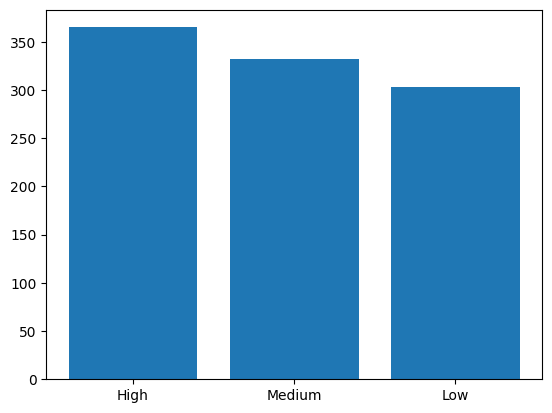

In [161]:
level_data = data['Level'].value_counts().reset_index()
plt.bar(level_data['Level'], level_data['count'])

In [77]:
# encoding target column
enc = LabelEncoder()
data['Level'] = enc.fit_transform(data['Level'])
classes = enc.classes_
classes

array(['High', 'Low', 'Medium'], dtype=object)

In [162]:
# data split
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['index', 'Patient Id', 'Level'], axis=1),
    data['Level'],
    test_size=0.3,
    random_state=1,
    shuffle=True
)

## RandomForestClassifier

In [163]:
rand_forest = RandomForestClassifier(criterion='gini', random_state=101)
rand_forest.fit(X_train, y_train)

y_pred = rand_forest.predict(X_test)

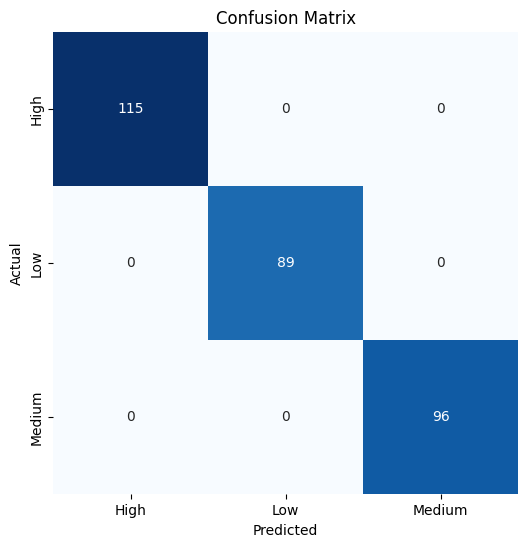

In [164]:
plt.figure(figsize = (6,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['High', 'Low', 'Medium'],
            yticklabels=['High', 'Low', 'Medium'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [165]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       1.00      1.00      1.00       115
         Low       1.00      1.00      1.00        89
      Medium       1.00      1.00      1.00        96

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



<BarContainer object of 23 artists>

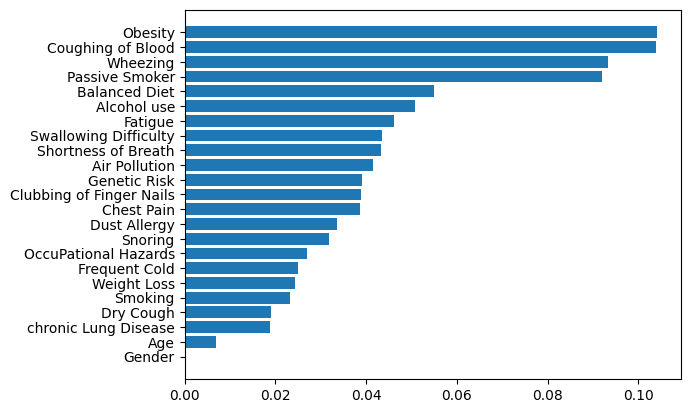

In [166]:
feature_importances = pd.DataFrame({'feature': X_train.columns.to_list(),
                                    'importance': rand_forest.feature_importances_}) \
                                        .sort_values(by='importance', ascending=True)

plt.barh(feature_importances['feature'], feature_importances['importance'])
